In [22]:
import keras
import warnings
warnings.filterwarnings('ignore')
import glob
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from lightgbm import LGBMClassifier
from sklearn.model_selection import StratifiedKFold
from sklearn.model_selection import KFold
from sklearn.preprocessing import OneHotEncoder
import random
import os
from sklearn.metrics import log_loss
from keras import models
from keras import layers

d = "C:\kaggle_data\credit_card"
lst = os.listdir(d)
print(lst)
train = pd.read_csv(d + '\\' +lst[3])
test = pd.read_csv(d + '\\' +lst[2])
ss = pd.read_csv(d + '\\' +lst[1])
train = train.drop(['index'], axis=1)
train.fillna('NAN', inplace=True) 
test = test.drop(['index'], axis=1)
test.fillna('NAN', inplace=True)

['.ipynb_checkpoints', 'sample_submission.csv', 'test.csv', 'train.csv', 'Untitled.ipynb']


In [23]:
y = train.pop('credit')
def simple_pp(train, test):
    
    # Married, Civil marriage
    train['income_per_size'] = np.log(train['income_total']/train['family_size'])
    test['income_per_size'] = np.log(test['income_total']/test['family_size'])
    train.loc[(train['family_type']=='Married')|(train['family_type']=='Civil marriage'),'income_per_size']\
    = train['income_per_size'] * 2
    test.loc[(test['family_type']=='Married')|(test['family_type']=='Civil marriage'),'income_per_size']\
    = test['income_per_size'] * 2
    
    train['gender'] =train['gender'].apply(lambda x: int(x=='F'))
    test['gender'] =test['gender'].apply(lambda x: int(x=='F'))
    
    
    def simple_marry(x):
        if x == 'Married' or x =='Civil marriage':
            return '0'
        elif x == 'Separated' or x == 'Widow':
            return '1'
        else:
            return '2'

    for df in [train,test]:
        df['family_bins'] = df['family_type'].apply(simple_marry)

    # car와 reality를 합친 새로운 칼럼 careality
    train['car'] =train['car'].apply(lambda x: int(x=='Y'))
    train['reality'] =train['reality'].apply(lambda x: int(x=='Y'))
    test['car'] =test['car'].apply(lambda x: int(x=='Y'))
    test['reality'] =test['reality'].apply(lambda x: int(x=='Y'))

    train['careality'] = train['car'] + train['reality']
    train = train.drop(['car', 'reality'],1)

    test['careality'] = test['car'] + test['reality']
    test = test.drop(['car', 'reality'],1)



    object_col = []
    for col in train.columns:
        if train[col].dtype == 'object':
            object_col.append(col)

    enc = OneHotEncoder()
    enc.fit(train.loc[:,object_col])


    train_onehot_df = pd.DataFrame(enc.transform(train.loc[:,object_col]).toarray(), 
                 columns=enc.get_feature_names(object_col))
    train.drop(object_col, axis=1, inplace=True)
    train = pd.concat([train, train_onehot_df], axis=1)

    test_onehot_df = pd.DataFrame(enc.transform(test.loc[:,object_col]).toarray(), 
                 columns=enc.get_feature_names(object_col))
    test.drop(object_col, axis=1, inplace=True)
    test = pd.concat([test, test_onehot_df], axis=1)

    ## 제곱
    for df in [train,test]:
        df['income_per_size'] = df['income_per_size'].apply(lambda x: x**2)
    
    return train,test
X, test = simple_pp(train,test)

In [39]:
def nn(input_shape):
    model = models.Sequential()
    model.add(layers.Dense(16, activation='relu', input_shape=(56,)))
    model.add(layers.Dense(8,activation='relu'))
    model.add(layers.Dense(3,activation='softmax'))

    model.compile(optimizer='rmsprop',
                     loss='sparse_categorical_crossentropy',
                     metrics=['acc'])
    return model

In [40]:
import keras
es = keras.callbacks.EarlyStopping(monitor='sparse_categorical_crossentropy',patience=50)

In [47]:
kf = KFold(n_splits=10, shuffle=False)
skf = StratifiedKFold(n_splits=5, shuffle=False)
hists = {}
for i, (train_idx, valid_idx) in enumerate(skf.split(X,y)):    
#     X_train= X.iloc[train_idx,:]
    model = nn(56)
    X_train, y_train = X.iloc[train_idx,:], y[train_idx]
    X_valid, y_valid = X.iloc[valid_idx,:], y[valid_idx]
    
    history = model.fit(x = X_train, 
                    y = y_train,
                   epochs=100,
#                    batch_size=24576,
                    batch_size=98304,
                   validation_data =(X_valid, y_valid),
                       verbose=100,
                       callbacks=[es])
    hists[i] = model

Train on 21165 samples, validate on 5292 samples
Epoch 1/250
Epoch 2/250
Epoch 3/250
Epoch 4/250
Epoch 5/250
Epoch 6/250
Epoch 7/250
Epoch 8/250
Epoch 9/250
Epoch 10/250
Epoch 11/250
Epoch 12/250
Epoch 13/250
Epoch 14/250
Epoch 15/250
Epoch 16/250
Epoch 17/250
Epoch 18/250
Epoch 19/250
Epoch 20/250
Epoch 21/250
Epoch 22/250
Epoch 23/250
Epoch 24/250
Epoch 25/250
Epoch 26/250
Epoch 27/250
Epoch 28/250
Epoch 29/250
Epoch 30/250
Epoch 31/250
Epoch 32/250
Epoch 33/250
Epoch 34/250
Epoch 35/250
Epoch 36/250
Epoch 37/250
Epoch 38/250
Epoch 39/250
Epoch 40/250
Epoch 41/250
Epoch 42/250
Epoch 43/250
Epoch 44/250
Epoch 45/250
Epoch 46/250
Epoch 47/250
Epoch 48/250
Epoch 49/250
Epoch 50/250
Epoch 51/250
Epoch 52/250
Epoch 53/250
Epoch 54/250
Epoch 55/250
Epoch 56/250
Epoch 57/250
Epoch 58/250
Epoch 59/250
Epoch 60/250
Epoch 61/250
Epoch 62/250
Epoch 63/250
Epoch 64/250
Epoch 65/250
Epoch 66/250
Epoch 67/250
Epoch 68/250
Epoch 69/250
Epoch 70/250
Epoch 71/250
Epoch 72/250
Epoch 73/250
Epoch 74/25

Epoch 101/250
Epoch 102/250
Epoch 103/250
Epoch 104/250
Epoch 105/250
Epoch 106/250
Epoch 107/250
Epoch 108/250
Epoch 109/250
Epoch 110/250
Epoch 111/250
Epoch 112/250
Epoch 113/250
Epoch 114/250
Epoch 115/250
Epoch 116/250
Epoch 117/250
Epoch 118/250
Epoch 119/250
Epoch 120/250
Epoch 121/250
Epoch 122/250
Epoch 123/250
Epoch 124/250
Epoch 125/250
Epoch 126/250
Epoch 127/250
Epoch 128/250
Epoch 129/250
Epoch 130/250
Epoch 131/250
Epoch 132/250
Epoch 133/250
Epoch 134/250
Epoch 135/250
Epoch 136/250
Epoch 137/250
Epoch 138/250
Epoch 139/250
Epoch 140/250
Epoch 141/250
Epoch 142/250
Epoch 143/250
Epoch 144/250
Epoch 145/250
Epoch 146/250
Epoch 147/250
Epoch 148/250
Epoch 149/250
Epoch 150/250
Epoch 151/250
Epoch 152/250
Epoch 153/250
Epoch 154/250
Epoch 155/250
Epoch 156/250
Epoch 157/250
Epoch 158/250
Epoch 159/250
Epoch 160/250
Epoch 161/250
Epoch 162/250
Epoch 163/250
Epoch 164/250
Epoch 165/250
Epoch 166/250
Epoch 167/250
Epoch 168/250
Epoch 169/250
Epoch 170/250
Epoch 171/250
Epoch 

Epoch 199/250
Epoch 200/250
Epoch 201/250
Epoch 202/250
Epoch 203/250
Epoch 204/250
Epoch 205/250
Epoch 206/250
Epoch 207/250
Epoch 208/250
Epoch 209/250
Epoch 210/250
Epoch 211/250
Epoch 212/250
Epoch 213/250
Epoch 214/250
Epoch 215/250
Epoch 216/250
Epoch 217/250
Epoch 218/250
Epoch 219/250
Epoch 220/250
Epoch 221/250
Epoch 222/250
Epoch 223/250
Epoch 224/250
Epoch 225/250
Epoch 226/250
Epoch 227/250
Epoch 228/250
Epoch 229/250
Epoch 230/250
Epoch 231/250
Epoch 232/250
Epoch 233/250
Epoch 234/250
Epoch 235/250
Epoch 236/250
Epoch 237/250
Epoch 238/250
Epoch 239/250
Epoch 240/250
Epoch 241/250
Epoch 242/250
Epoch 243/250
Epoch 244/250
Epoch 245/250
Epoch 246/250
Epoch 247/250
Epoch 248/250
Epoch 249/250
Epoch 250/250


In [30]:
hists[0].history.history.keys()

dict_keys(['val_loss', 'val_acc', 'loss', 'acc'])

In [70]:
def return_plot(i):
    
    val_ent = hists[i].history.history['val_loss']
    trn_ent = hists[i].history.history['loss']
    
    val_acc = hists[i].history.history['val_acc']
    trn_acc = hists[i].history.history['acc']
    
    epochs = range(1,len(val_ent)+1)

    fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(12,8))
#     ax1 = plt.subplot(121)
    sns.lineplot(x=epochs, y=val_ent,ax=ax[0])
    sns.lineplot(x=epochs, y=trn_ent,ax=ax[0])
    
#     ax2 = plt.subplot(122)
    sns.lineplot(x=epochs, y=val_ent,ax=ax[1])
    sns.lineplot(x=epochs, y=trn_ent,ax=ax[1])
    
    plt.show()

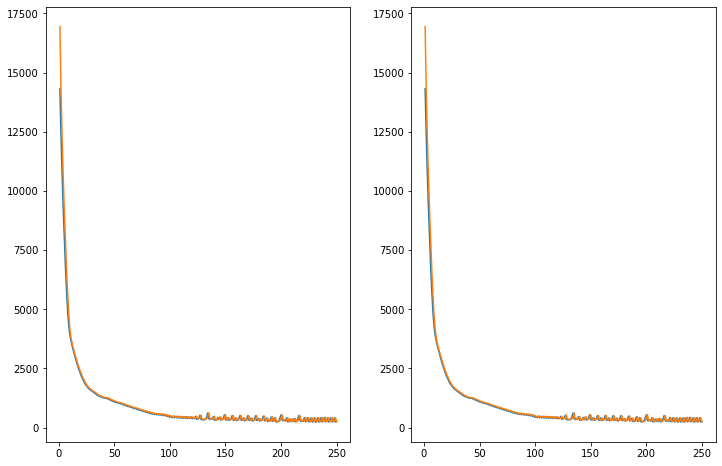

In [71]:
return_plot(1)

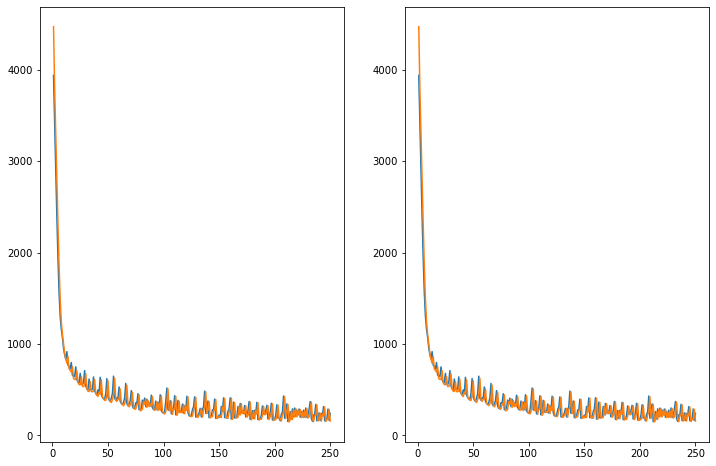

In [72]:
return_plot(2)

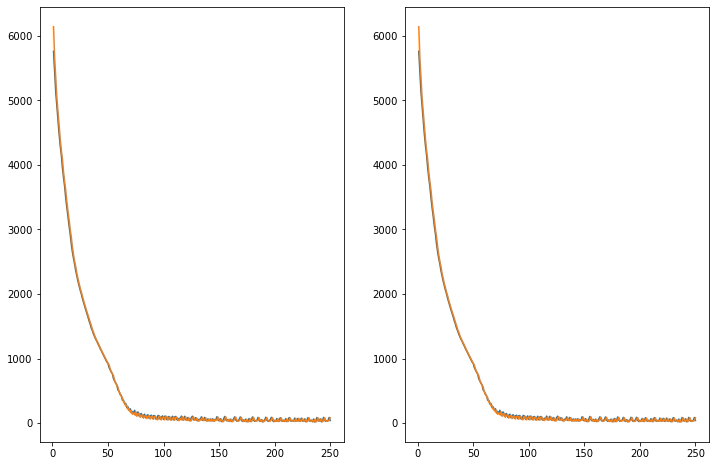

In [73]:
return_plot(3)

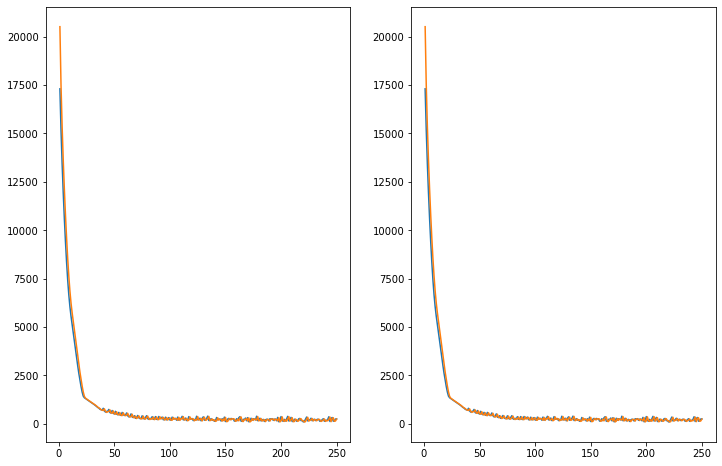

In [74]:
return_plot(4)

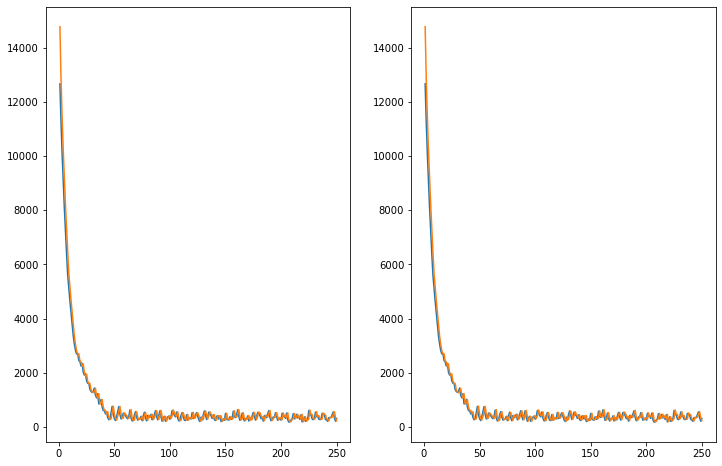

In [75]:
return_plot(0)